<a href="https://colab.research.google.com/github/ZvikaZ/SCIgan/blob/master/SCIgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SCIgan - An Automatic CS Paper Generator#

## Data Science Workshop
#### By Elad Yitzhaik and Zvika Haramaty
#### Mentor: Idan Alter
#### 14 August 2020

# Introduction

In this work, we've tried to auto generate papers CS papers, by using GAN (Generative Adversarial Networks).

The work is divided to four parts (we'll later elaborate on each of them):
- Preprocessing
- Textual Classifier
- GAN
- GAN/Textual Classifier combination


## History

There were several similar attempts, in various directions. The most famous one is probably [SCIgen - An Automatic CS Paper Generator](https://pdos.csail.mit.edu/archive/scigen/) created at circa 2005 by (then) two graduate students at MIT. One of their generated papers was even admitted to a conference...

Although the SCIgen inspired us, it's using a completely different technology - a hand-written context-free grammar.

However, there are even earlier scientific paper generators - such as http://www.elsewhere.org/pomo/, from 1 April 1996, which specialize at generating Post Modernism papers.

That leads us to maybe the most famous fictive scientific paper - [the Sokal hoax](https://en.wikipedia.org/wiki/Sokal_affair). Alan Sokal, a physics professor, sent a meaningless paper, titled "Transgressing the Boundaries: Towards a Transformative Hermeneutics of Quantum Gravity", to a social studies magazine, and it was surprisingly admitted.

Indeed, Sokal didn't use any automatic generators; however, he raised the question of the boundaries between real, meaningful, scientific papers, and bogus papers.

Sadly, analyzing the full implications of Sokal hoax is beyond the scope of this work.

More recent attempt with text generation is [Andrej Karpathy's 'The Unreasonable Effectiveness of Recurrent Neural Networks'](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). He's using a different attitude, of character level generation with RNN, and without GAN; and achieved  quite impressing results, such as fake Wikipedia article, fake scientific paper and even fake Linux kernel source code (including license and comments...)

An interesting review of the 2018 advances in NLP, relevant to our work -  "Finally, a Machine That Can Finish Your Sentence" can be found at [this NY Times article](https://www.nytimes.com/2018/11/18/technology/artificial-intelligence-language.html).

## The Data

We need a large collection of CS papers; some of them published in journals, some of them aren't. A useful option is [arXiv.org](https://arxiv.org/), because it's becoming a common practice to pre-publish papers over there, until the peer review process will finish. Therefore, if we check old enough papers over there, we can distinguish between papers that have been peer reviewed and accepted to publication, and papers that haven't.

Furthermore, the arXiv has the original .tex files, which make it easier to analyze (we don't need to run PDFs through OCR).

## Textual Classifier

We've built a state-of-the-art Textual Classifier, based on the following principles:

### Transfer learning

Following [fast.ai documentation](https://docs.fast.ai/text.html), we're using transfer learning - instead of training our models from scratch, we start from a "good known point" - similar to what is done in vision - where models come pre-trained on [ImageNet](http://www.image-net.org/), and only the last layers are fine tuned. Similar approach for text is using [ULMFiT](https://arxiv.org/abs/1801.06146)(Universal Language Model Fine-tuning for Text Classification), a model that has already been trained over the English Wikipedia, and therefore knows a lot about English texts, and only needs fine tuning for the specific field.

### Language model ###

In our approach, we first train a `language model`, that receives a word, and predicts what the next word will be. ~30% accuracy is thought to be good for the general case, and can raise up to 50% for specific fields. We've achieved ~33%.

In this phase, we don't care whether a paper is peer reviewed, or not; we just want our model to 'understand' how text from all kinds of papers look like and 'behave'.

### Classifier ###

With the language model at hand, we can build a classifier. Conveniently, `fast.ai` wraps `NLTK`, and our language model handles the tokenization and conversion to numbers. Now all we need to do is give our language model a labeled dataset, and let it distinguish between peer reviewed and not peer reviewed papers.

## GAN

### What is GAN?
GAN (Generative Adversarial Networks) is a generative model, which can create new data instances that resemble the training data. It works by using two networks - a **generator**, which learns to produce the target output, and a **discriminator**, which learns to distinguish true data from the output of the generator. The generator tries to fool the discriminator, and the discriminator tries to keep from being fooled.

In this work we've used the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

### The problem
GANs are usually implemented for vision. How can we implement GAN for texts?

### The solution
We've built an encoder/decoder that translates texts to images, and vice-versa.
Thus, out textual papers are translated to images (each image representing a single paper), the GAN is feeded with the images and generates new images based on the existing images (which are, as aforesaid, papers representions). Now we translate back each of the generated images to text, and we receive the *generated papers*.


## GAN/Textual Classifier combination
We described so far two **different** systems:
- State of the art Textual Classifier, with good knowledge of texts in general, and capable of reliably differentiate between peer reviewed and not peer reviewed papers
- Textual GAN, based on vision GAN - which lacks knowledge of our text domain

### Uniting the two systems
How can we harness the qualities of Textual Classifier, to improve the generated result?

We've generated a batch of papers with our GAN. Then each one one of them was classified by the Textual Classifier.
Thus, we earn two things:
- Feedback regarding the quality of the GAN: the higher the percentage of the papers that passed the Textual Classifier (i.e., predicted as 'peer-reviweed'), the better the quality of the GAN
- Improving the overall performance of the papers generation system - instead of supplying the papers straight from the GAN, the system will return only the papers that were approved by the Textual Classifier




# Setup

In [ ]:
# setup

%matplotlib inline

import sys
!{sys.executable} -m pip install arxiv
!{sys.executable} -m pip install arxivscraper

from fastai.text import *
from fastai.vision import *
from fastai.vision.gan import *
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = os.path.join(root_dir, 'fastai-v3/SCIgan/')
papers_folder = os.path.join(base_dir, "papers")
generated_dir = os.path.join(base_dir, "generated")

batch_size = 48

np.random.seed(1)

import stat
import urllib.request
import subprocess

url = 'https://github.com/eladyitz/article-generator/raw/master/bin/detex'
urllib.request.urlretrieve(url, '/usr/local/bin/detex')
os.chmod("/usr/local/bin/detex", stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR)

import pandas as pd
from IPython.display import display
import enum
import datetime
import shutil
import tarfile
from urllib.request import urlretrieve
import arxiv
import concurrent.futures
import re
from time import mktime
import subprocess
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from random import randint
from PIL import Image
import math
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

nltk.download('punkt')

     |████████████████████████████████| 194kB 7.8MB/s 
  Created wheel for feedparser: filename=feedparser-5.2.1-cp36-none-any.whl size=44940 sha256=4b61097f6bb045f954264b8a9619eea80a3fc262ad8d3c6dc02686e170d0c4f0
  Stored in directory: /root/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
Successfully built feedparser
  Created wheel for arxivscraper: filename=arxivscraper-0.0.3-cp36-none-any.whl size=7400 sha256=a591c785ab6f2d357d6030c63b52f6a0885641a57105a1eafeadbb2ae12dc8bc
  Stored in directory: /root/.cache/pip/wheels/99/19/63/986c0f115433d38ed25eb600ae067ab7e6bc360f5682c1a8a3
Successfully built arxivscraper
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapi

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Preprocessing


Preprocessing phase is composed of:
- Scraping the articles from arXiv.org
- Parsing the articles (e.g., consolidation of several .tex files to a single file)
- Converting the texts to images (for the GAN)
- Producing Data Statistics

## Scraping and Parsing articles from https://arxiv.org ##


In [ ]:
class DbName(enum.Enum):
    arxiv = 1

class DataActions(enum.Enum):
    metadata_only = 1
    download_files_only = 2
    metadata_and_files_content = 3
    test_parser = 4

class ArxivDbQuery:
    def __init__(self, query, from_date, to_date=None, id_list=[], max_results=None, start=0, sort_by="submittedDate",
                 sort_order="descending", prune=True, max_chunk_results=1000):
        self.query = query
        self.from_date = from_date
        if to_date is None:
            self.to_date = datetime.datetime.now()
        else:
            self.to_date = to_date
        self.id_list = id_list
        self.max_results = max_results
        self.start = start
        self.sort_by = sort_by
        self.sort_order = sort_order
        self.prune = prune
        self.max_chunk_results = max_chunk_results

    def __str__(self):
        return str(self.__dict__)


def get_components_list(db_name, component):
    if db_name == DbName.arxiv and component == "cs":
        return ["cs.AI",
                "cs.AR",
                "cs.CC",
                "cs.CE",
                "cs.CG",
                "cs.CL",
                "cs.CR",
                "cs.CV",
                "cs.DB",
                "cs.DC",
                "cs.DL",
                "cs.DM",
                "cs.DS",
                "cs.ET",
                "cs.FL",
                "cs.GL",
                "cs.GR",
                "cs.GT",
                "cs.HC",]
                # "cs.IR",
                # "cs.IT",
                # "cs.LG",
                # "cs.LO",
                # "cs.MAv",
                # "cs.MM",
                # "cs.MS",
                # "cs.NA",
                # "cs.NE",
                # "cs.NI",
                # "cs.OH",
                # "cs.OS",
                # "cs.PF",
                # "cs.PL",
                # "cs.RO",
                # "cs.SC",
                # "cs.SD",
                # "cs.SE",
                # "cs.SI",
                # "cs.SY"]


def get_data_from_db(db_name, queries, data_action, folder):
    if not issubclass(db_name.__class__, DbName) and issubclass(data_action.__class__, DataActions):
        raise Exception("DB name {} and Data action {} must be allowed".format(db_name), data_action)

    if not db_name == DbName.arxiv and len(queries) > 0 and len(
            [query for query in queries if issubclass(query.__class__, ArxivDbQuery)]) is not len(queries):
        raise Exception("DB name {} and queries type {} must be allowed".format(db_name), data_action)

    if data_action == DataActions.metadata_only:
        return _get_meta_data(queries)
    elif data_action == DataActions.download_files_only:
        papers_metadata = _get_meta_data(queries)
        return _download_papers(papers_metadata, folder)
    elif data_action == DataActions.metadata_and_files_content:
        papers_metadata = _get_meta_data(queries)
        _download_papers(papers_metadata, folder)
        papers_metadata = _add_text_to_metadata(papers_metadata)
        return papers_metadata
    elif data_action == DataActions.test_parser:
        papers_metadata = _get_meta_data(queries)
        papers_metadata = _add_text_to_metadata(papers_metadata)
        return papers_metadata


def _get_meta_data(queries):
    queries_results = set()

    print("######################### Querying DB #################################")
    print()
    queries_count = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(queries)) as query_puller:
        future_to_query = {query_puller.submit(_query, query): query for query in queries}

        for future_query_result in concurrent.futures.as_completed(future_to_query):
            query_details = future_to_query[future_query_result]
            try:
                query_data = future_query_result.result()
                queries_results.update(query_data)
                queries_count += 1
            except Exception as exc:
                print('query {} returned exception {}'.format(query_details, exc))
        
        print("Querys count {}".format(queries_count))
        print()
        return queries_results


def _query(query):
    query_result = arxiv.query(
        query=query.query,
        id_list=query.id_list,
        max_results=query.max_results,
        start=query.start,
        sort_by=query.sort_by,
        sort_order=query.sort_order,
        prune=query.prune,
        max_chunk_results=query.max_chunk_results
    )

    query_result = list(filter(
        lambda result: query.from_date <= datetime.datetime.fromtimestamp(mktime(result['published_parsed'])) <= query.to_date,
        query_result))
    return query_result


def _download_papers(papers_metadata, path):
    _clean_workspace(path)

    print("####################### Download Articles ###################################")
    print()
    papers_counter = 0
    with concurrent.futures.ThreadPoolExecutor() as paper_downloader:
        future_to_paper = {
            paper_downloader.submit(_download_paper, paper, path): paper for paper in papers_metadata
        }

        for future_paper_result in concurrent.futures.as_completed(future_to_paper):
            paper_metadata = future_to_paper[future_paper_result]
            try:
                download_details = future_paper_result.result()
                paper_metadata['paper_prefix_path'] = path
                paper_metadata['paper_file_name'] = download_details["file_name"]
                paper_metadata['paper_full_path'] = download_details["file_path"]
                papers_metadata.add(paper_metadata)
                papers_counter += 1
            except Exception as exc:
                print("Cant download {} because {}".format(download_details["url"], exc))
                paper_metadata['for_deletion'] = True

        print("Papers downloaded {}".format(papers_counter))
        print()
        return path


def _download_paper(paper, path):
    success = False
    attempts = 0
    while not success and attempts <= 3:
        try:
            url = paper['pdf_url'].replace("http://arxiv.org/pdf", "https://export.arxiv.org/e-print")
            file_name = "{}.tar.gz".format(paper['id'].split('/')[-1].replace(".", "_"))
            file_path = os.path.join(path, file_name)
            urlretrieve(url, file_path)
            success = True
        except Exception as exc:
            attempts += 1

    return {"url": url, "file_name": file_name, "file_path": file_path}


def _clean_workspace(path):
    if os.path.exists(path):
        try:
            shutil.rmtree(path)
        except OSError as e:
            print("Cant delete dir {}, {}".format(path, e.strerror))
    os.mkdir(path)


def _untar_paper_zip(paper):
    extracted_folder = "{}_{}".format(paper['paper_full_path'], "extracted")
    try:
        my_tar = tarfile.open(paper['paper_full_path'])
        os.mkdir(extracted_folder)
        my_tar.extractall(extracted_folder)
        my_tar.close()
        os.remove(paper['paper_full_path'])
        paper['paper_full_path'] = extracted_folder
        return True
    except Exception as exc:
        if os.path.exists(paper['paper_full_path']):
            os.remove(paper['paper_full_path'])
        if os.path.exists(extracted_folder):
            os.remove(extracted_folder)
        return False


def _create_folder_for_sorting(paper):
    if not paper["journal_reference"]:
        folder_name = "not_peer_reviewed"
    else:
        folder_name = "peer_reviewed"

    folder_path = os.path.join(paper["paper_prefix_path"], folder_name)
    paper["paper_prefix_path"] = folder_path
    paper["paper_folder_label"] = folder_name
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)


def _add_text_to_metadata(papers_metadata):
    print("######################### Consolidate Papers #################################")
    print()
    papers_consolidated_counter = 0
    papers_corrupted = 0
    papers_cant_be_consolidated = 0
    for paper in papers_metadata:
        if _untar_paper_zip(paper):
            _create_folder_for_sorting(paper)
            consolidated_paper = consolidate_papers(paper)
            if consolidated_paper:
                paper["paper_text"] = consolidated_paper
                paper['for_deletion'] = False
                papers_consolidated_counter += 1
            else:
                paper['for_deletion'] = True
                papers_cant_be_consolidated += 1
        else:
            paper['for_deletion'] = True
            papers_corrupted += 1

    print("Papers consolidated {}".format(papers_consolidated_counter))
    print("Papers zip corrupted {}".format(papers_corrupted))
    print("Papers format can't be consolidated {}".format(papers_cant_be_consolidated))
    print()

    papers_metadata = list(filter(lambda x: not x['for_deletion'], papers_metadata))

    return papers_metadata

def _get_main_tex_file(tex_dir, tex_files):
    r = re.compile(r'^\s*\\documentclass')
    for tex_file in tex_files:
        filename = os.path.join(tex_dir, tex_file)
        with open(filename, 'r', encoding='utf-8') as f:
            try:
                for line in f:
                    if r.match(line):
                        return tex_file
            except UnicodeDecodeError as exc:
                # print("Decoding error in: {}, reason: {}".format(filename, exc))
                return None
    return None


def consolidate_papers(paper):
    tex_files = [file for file in os.listdir(paper['paper_full_path']) if file.endswith(".tex")]
    new_paper_file_name = "{}.txt".format(paper['paper_file_name'])
    consolidated_paper = os.path.join("..", paper['paper_folder_label'], new_paper_file_name)

    if "main.tex" in tex_files:
        main_tex = "main.tex"
    elif len(tex_files) == 1:
        main_tex = tex_files[0]
    else:
        main_tex = _get_main_tex_file(paper['paper_full_path'], tex_files)
        if not main_tex:
            # print("there is no main.tex and there is more than 1 file in folder: {}".format(paper['paper_full_path']))
            return None

    current_path = os.getcwd()
    os.chdir(paper['paper_full_path'])
    subprocess.run("detex {} > {}".format(main_tex, consolidated_paper),
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                            check=True,
                            shell=True)

    try:
        with open(consolidated_paper, "r+", encoding='utf-8') as paper_file:
            paper_content = paper_file.read()
            paper_content = re.sub(r'\n\s*\n', '\n\n', paper_content)
            paper_file.seek(0)
            paper_file.write(paper_content)
            paper_file.truncate()
    except UnicodeDecodeError as exc:
        # print("Decoding error in: {}, reason: {}".format(consolidated_paper, exc))
        os.remove(consolidated_paper)
        paper_content = None

    try:
        os.chdir(current_path)
        shutil.rmtree(paper['paper_full_path'])
    except OSError as exc:
        print("Cant delete dir {}, {}".format(paper['paper_full_path'], exc))

    paper['paper_file_name'] = new_paper_file_name
    paper['paper_full_path'] = os.path.join(paper['paper_prefix_path'], new_paper_file_name)

    return paper_content


################################################ Main ######################################################

max_results = 1000
years_ago = 1.5
years_period = 8
to_date = datetime.datetime.now() - datetime.timedelta(days=years_ago*365)
from_date = to_date - datetime.timedelta(days=years_period*365)

components_list = get_components_list(DbName.arxiv, "cs") # AI
queries = set()
for component in components_list:
    queries.add(ArxivDbQuery("cat:{}".format(component), from_date=from_date, to_date=to_date, max_results=max_results)) # 3 years

data = get_data_from_db(DbName.arxiv, queries, DataActions.metadata_and_files_content, folder=papers_folder)

# data can be used as data frame
cols = tuple(list(data)[0].keys())
df = pd.DataFrame(data, columns=cols)
df.to_excel(os.path.join(papers_folder, "articles_data.xlsx"))

######################### Querying DB #################################

Querys count 19

####################### Download Articles ###################################

Papers downloaded 2198

######################### Consolidate Papers #################################

Papers consolidated 1485
Papers zip corrupted 678
Papers format can't be consolidated 35



## Convert Text to Images

We tokenize all the texts, creating a list of all possible tokens in all texts. Then we give each token a numerical value (based on its index in the list).

In order to translate text to image:
- The text is tokenized. Now the text is represented as list of tokens
- The tokens are replaced with the numerical value. Now the text is represented as list of numerical values
- We build the picture, each pixel representing a token
- The pixel's color value is a function of the token's numerical value

Our function is simply a multiplication, which is easy to reverse. It's based on the `ratio` between possible number of tokens and possible number of colors.

In [ ]:
class DataConverter:
    def __init__(self, excelPath):
        self.excel_data = pd.read_excel(excelPath)
        self.excel_path = excelPath
        self.tokenized_text = self._tokenizeText()
        self.hashed_tokenized_text = {k: v for v, k in enumerate(self.tokenized_text)}
        self.num_of_colors = 0xFFFFFF
        self.ratio = self.num_of_colors / len(self.tokenized_text)
        print("DataConverter ratio is: ", self.ratio)


    def _tokenizeText(self):
        data = self.excel_data["paper_text"]
        tokenized_text = set()
        for text in data:
            tokenized_text.update([each_string.lower() for each_string in nltk.word_tokenize(text)])

        return list(tokenized_text)


    def _getImageFromTokens(self, tokenized_paper):
        image_size = int(math.ceil(math.sqrt(len(tokenized_paper))))
        # 0x000000 (black) the background
        img = Image.new('RGB', (image_size, image_size), 0x000000) # Create a new black image
        pixels = img.load() # Create the pixel map
        token_index = 0
        for i in range(image_size):    # For every pixel:
            for j in range(image_size):
                    if token_index < len(tokenized_paper):
                        token = tokenized_paper[token_index]
                        token_value = self.hashed_tokenized_text[token]
                        color = round(token_value * self.ratio)
                        pixels[j, i] = ((color >> 16) & 255, (color >> 8) & 255, color & 255)
                        token_index += 1

        return img

    def convertTextsToColorImages(self):
        images_file_paths = []
        missed_image_conversions = 0

        for index, row in self.excel_data[["paper_full_path", "paper_text"]].iterrows():
            try:
                tokenized_paper = [each_string.lower() for each_string in nltk.word_tokenize(row["paper_text"])]
                img = self._getImageFromTokens(tokenized_paper)
                image_file_path = row["paper_full_path"].replace(".txt", ".png")
                img.save(image_file_path)
                images_file_paths.append(image_file_path)
            except Exception as exc:
                print("Error: ", row["paper_full_path"], exc)
                missed_image_conversions += 1
                images_file_paths.append("")

        self.excel_data["image_file_path"] = images_file_paths
        self.excel_data = self.excel_data.drop(self.excel_data[self.excel_data["image_file_path"] == ""].index)
        self.excel_data.to_excel(self.excel_path)

        print("######################### Convert Text To Images #################################")
        print()
        print("Papers converted {}".format(len(self.excel_data)))
        print("Papers not converted {}".format(missed_image_conversions))
        print()

    def convertColorImageToText(self, image_path, converted_file_path):
        tokens = []
        with Image.open(image_path) as img:
            pixel_values = list(img.getdata())
            for r, g, b in pixel_values:
                color = (r << 16) + (g << 8) + b
                if color != 0:
                    token_value = round(color / self.ratio)
                    token = self.tokenized_text[token_value]
                    tokens.append(token)

        # text = " ".join(text)
        text = TreebankWordDetokenizer().detokenize(tokens)

        with open(converted_file_path, "w") as writer:
            writer.write(text)

    def saveTokensOnFile(self, path):
        with open(path, 'w', encoding='utf-8') as inf:
            inf.write(json.dumps(self.getTextToColorDictionary()))


In [ ]:
dataConverter = DataConverter(os.path.join(papers_folder, "articles_data.xlsx"))
dataConverter.convertTextsToColorImages()

DataConverter ratio is:  115.50260233797349
Error:  /content/gdrive/My Drive/fastai-v3/SCIgan/papers/not_peer_reviewed/1803_10267v1.tar.gz.txt tile cannot extend outside image
######################### Convert Text To Images #################################

Papers converted 1484
Papers not converted 1



## Data Statistics

######################### Article Peer Review #################################


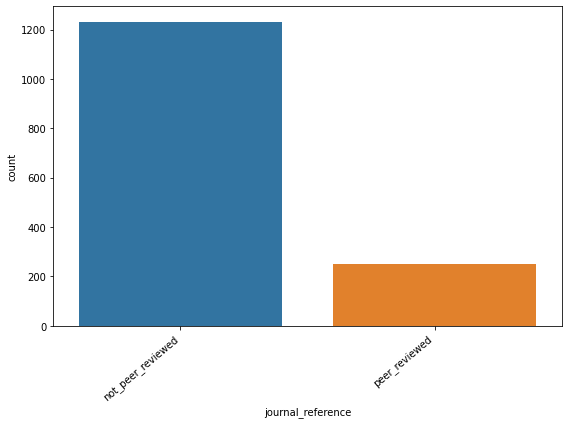

In [ ]:
df = pd.read_excel (r'{}'.format(os.path.join(papers_folder, "articles_data.xlsx")))

print("######################### Article Peer Review #################################")
d = df["journal_reference"].replace(to_replace="(?s).*", value="peer_reviewed", inplace=False, limit=None, regex=True, method='pad')
d = d.replace(to_replace=np.nan, value="not_peer_reviewed", inplace=False, limit=None, regex=False, method='pad')
plt.figure(figsize=(8,6))
ax = sns.countplot(d, label="Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

######################### Article Published Year #################################


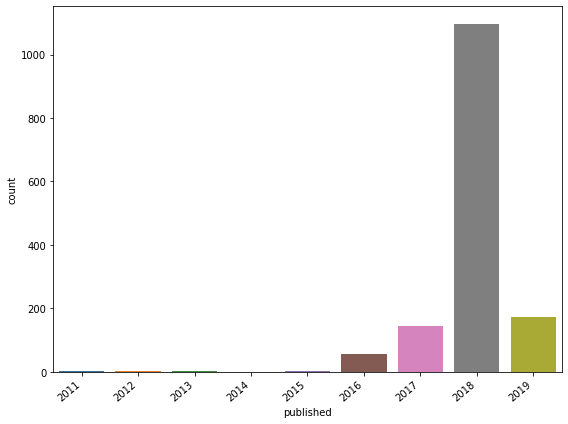

In [ ]:
print("######################### Article Published Year #################################")
p = pd.to_datetime(df["published"])
plt.figure(figsize=(8,6))
ax = sns.countplot(p.dt.year, label="Published Year")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

######################### Article Text Length #################################


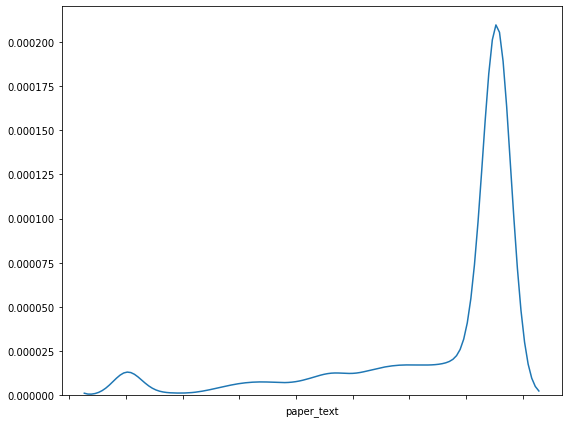

In [ ]:
print("######################### Article Text Length #################################")
s = df["paper_text"].str.len()
plt.figure(figsize=(8,6))
ax = sns.distplot(s, hist=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

######################### Article Tags #################################


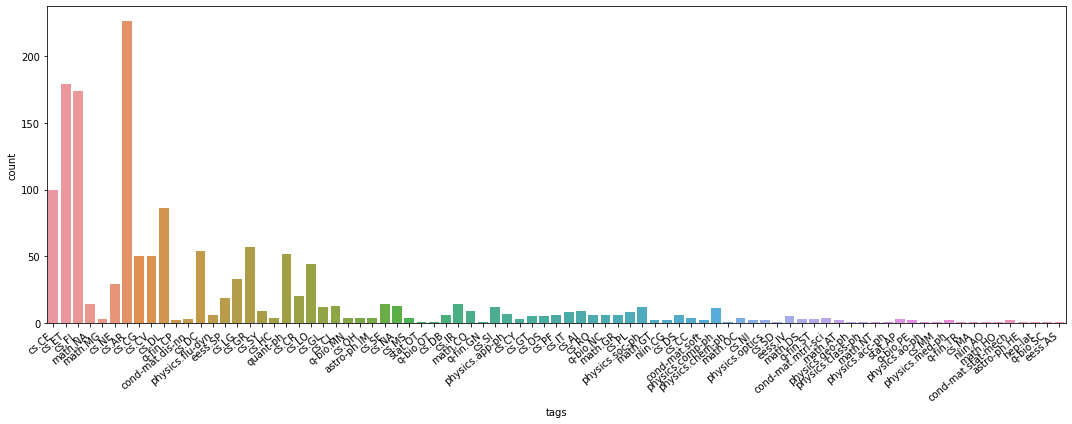

In [ ]:
print("######################### Article Tags #################################")
t = df["tags"].transform(lambda tag: eval(tag)[0]["term"])
plt.figure(figsize=(15,6))
ax = sns.countplot(t, label="Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# Textual Classifier


## Language Model

As described in the introduction, after gathering the data, we build a language model - a model that predicts what the next word in the sentence will be.

In [ ]:
# take the .txt files
# randomly split and keep 10% for validation
# in this phase, we don't care what's the label of paper (peer reviewed or not)
data_lm = TextList.from_folder(papers_folder, extensions={'.txt'}).split_by_rand_pct(0.1).label_for_lm().databunch(bs = batch_size)
          
# through out our code, we'll `save` sometimes, and `load` afterwards
# this allows continuing a new session from the middle, without
# having to start all over again
data_lm.save(base_dir + 'data_lm.pkl')


In [ ]:
data_lm = load_data(papers_folder, base_dir + 'data_lm.pkl', bs=batch_size)
 
# transfer learning, starting with Wikipedia model, and fine tuning with our data
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


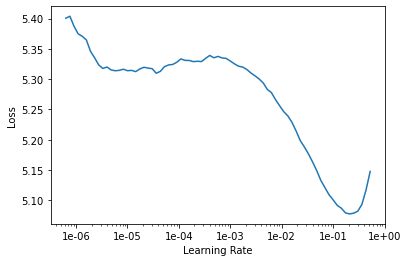

In [ ]:
# explore and plot the learning rates
learn.lr_find() 
learn.recorder.plot(skip_end=15)

In [ ]:
# train the language model
# we can see from the previous graph that 1e-1 is a good point,
# the loss is still decreasing, and before overfitting
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

# and save our good work
learn.save(base_dir + 'fit_head')
learn.save_encoder(base_dir + 'fit_head_enc')


epoch,train_loss,valid_loss,accuracy,time
0,4.541492,4.439379,0.277144,22:46


In [ ]:
# we have reached an accuracy of ~27%, but let's improve it:

# fine tune
learn.load(base_dir + 'fit_head');
learn.unfreeze()
learn.fit_one_cycle(8, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.786031,4.064780,0.313246,25:53
1,3.793305,4.084411,0.313067,25:58
2,3.609532,3.976020,0.322061,25:59
3,3.664933,3.904403,0.328327,25:58


Buffered data was truncated after reaching the output size limit.

In [ ]:
# save the model and the encoder
learn.save(base_dir + 'fine_tuned')
learn.save_encoder(base_dir + 'fine_tuned_enc')

In [ ]:
# let's check the language model - continue the sentence with 10 random words
learn.load(base_dir + 'fine_tuned');
learn.predict("This is a survey", n_words=10)

'This is a survey of central research questions and directions . \n  ['

## Classifier

As described in the introduction, with the learning model we can start build the classifier itself.


In [ ]:
# build a classifier with:
# - the .txt files
# - same vocabulary used in language model
# - 80% of the data used for learning, 20% of the data used for validation
# - use labels ["peer_reviewed", "not_peer_reviewed"] according to folder names
data_clas = TextList.from_folder(papers_folder, extensions={'.txt'}, vocab=data_lm.vocab).split_by_rand_pct(0.2).label_from_folder(classes=["peer_reviewed", "not_peer_reviewed"]).databunch(bs = batch_size)
 
data_clas.save(base_dir + 'data_clas.pkl')

In [ ]:
data_clas = load_data(papers_folder, base_dir + 'data_clas.pkl', bs=batch_size)
 
# We can now create a model to classify those reviews and load the encoder we saved before.
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(base_dir + 'fine_tuned_enc')
print()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


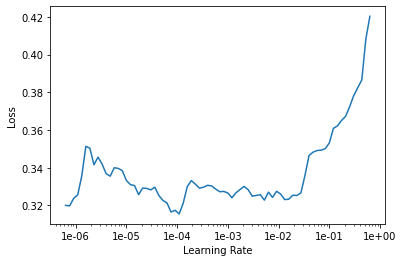

In [ ]:
# explore and plot the learning rates
learn.lr_find()
learn.recorder.plot()

In [ ]:
# according to the graph, it seems that 2e-2 is a good point -
# the loss is decreasing, before overfitting
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
learn.save(base_dir + 'first')

epoch,train_loss,valid_loss,accuracy,time
0,0.648227,0.529148,0.808081,06:14


In [ ]:
# now we start 'peeling' layer after layer, and fine tune
learn.load(base_dir + 'first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save(base_dir + 'second')

epoch,train_loss,valid_loss,accuracy,time
0,0.473476,0.482291,0.808081,06:38


In [ ]:
learn.load(base_dir + 'second');
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save(base_dir + 'third')

epoch,train_loss,valid_loss,accuracy,time
0,0.400365,0.469633,0.811448,07:01


In [ ]:
learn.load(base_dir + 'third');
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3) , moms=(0.8,0.7))
learn.save(base_dir + 'final')

epoch,train_loss,valid_loss,accuracy,time
0,0.355581,0.461168,0.811448,07:17
1,0.346435,0.458919,0.818182,07:38


# GAN

## Prepare data:

In [ ]:
def get_data(bs, size):
    return (GANItemList.from_folder(os.path.join(papers_folder, "peer_reviewed"), noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

data = get_data(128, 64)    

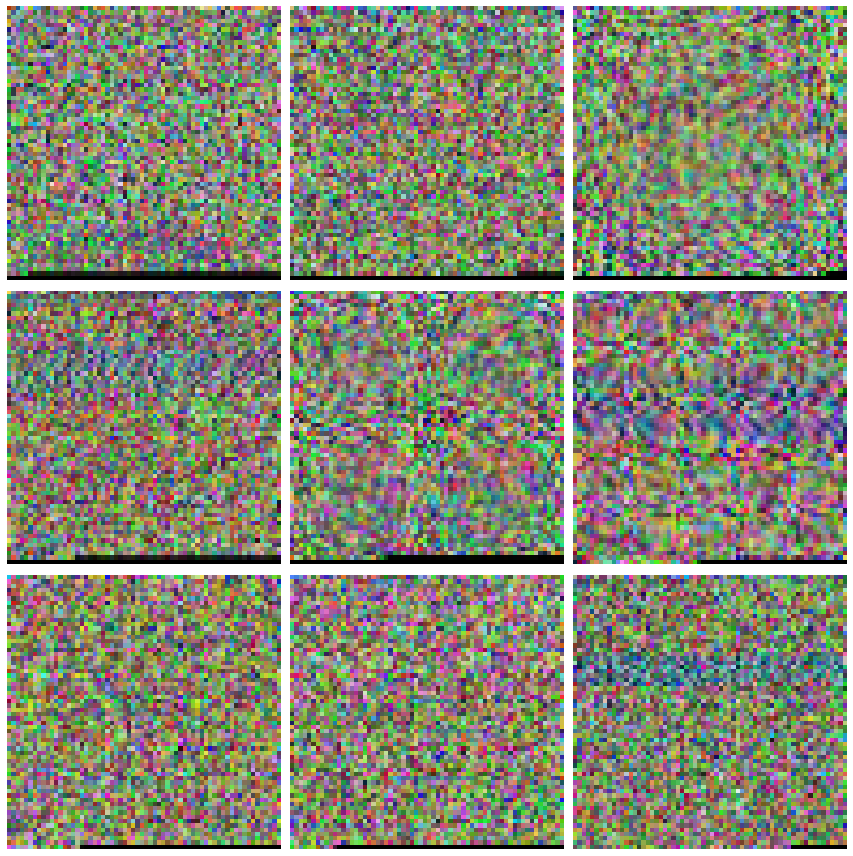

In [ ]:
# Show an example the learnt images:
data.show_batch(rows=3)

## GAN Models:

In [ ]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)
gan_learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

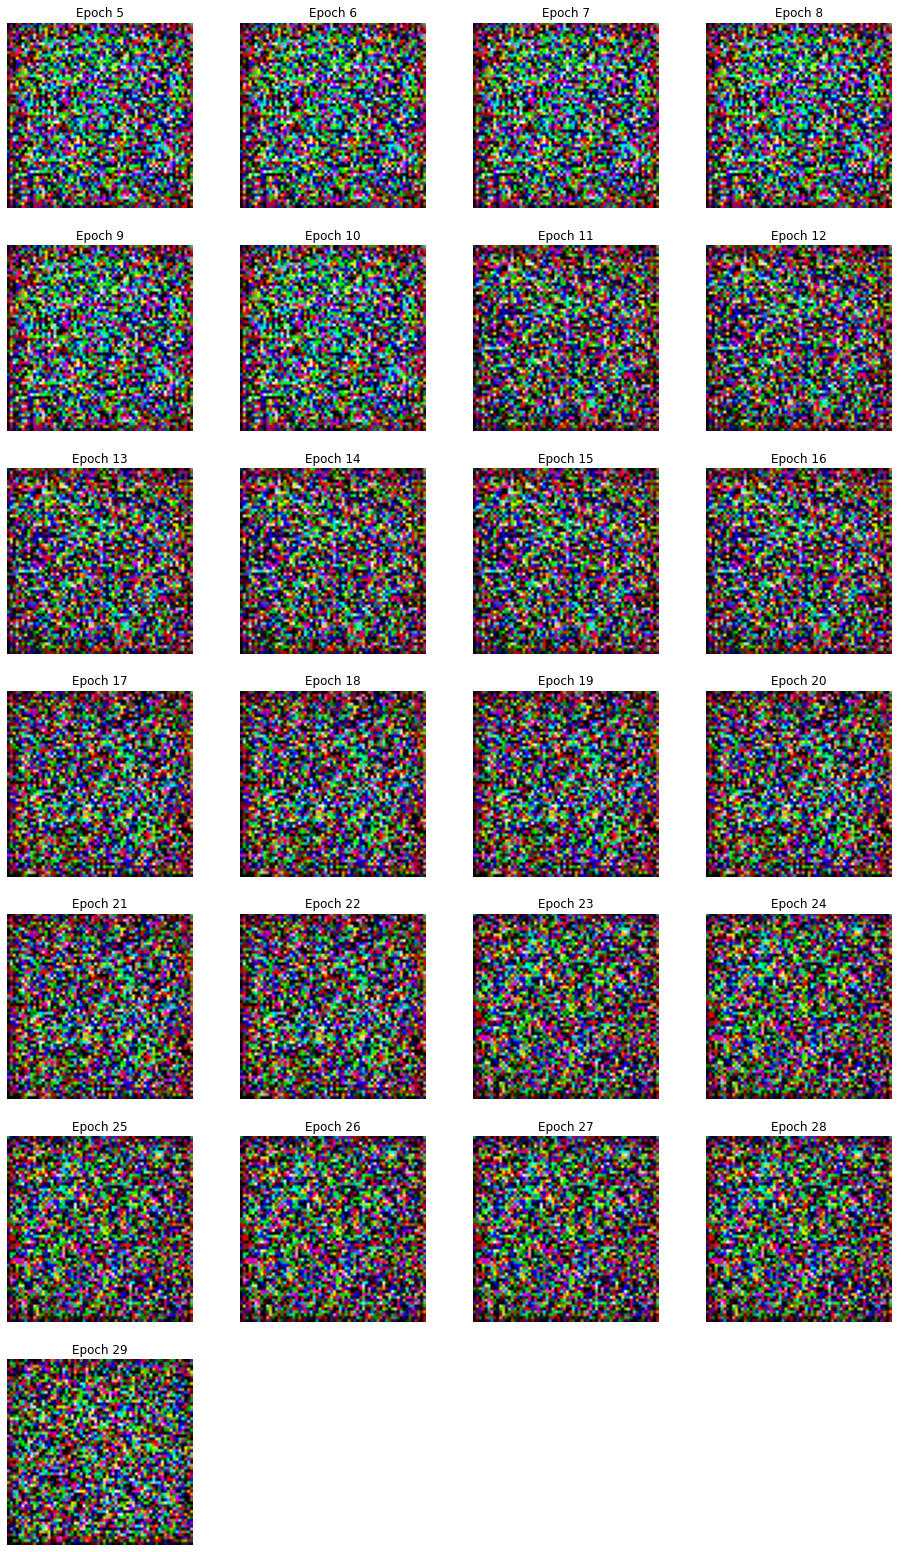

In [ ]:
# Let the GAN practice:
gan_learn.fit(30,2e-4)

# GAN/Textual Classifier combination

In [ ]:
learn.load(base_dir + 'final')
dataConverter = DataConverter(os.path.join(papers_folder, "articles_data.xlsx"))

In [ ]:
gan_learn.gan_trainer.switch(gen_mode=True)

## Combined generation

As described in the Introduction, here we combine the GAN and our Textual Classifier - we let the GAN generate a batch of 128 images, and then the Classifier checks them.

Few generated pictures:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


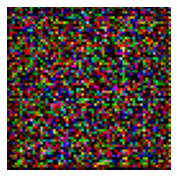

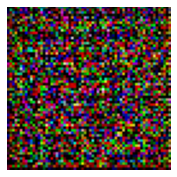

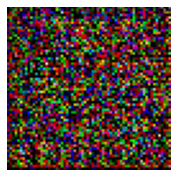

In [ ]:
try:
    shutil.rmtree(generated_dir)
except:
    pass
os.mkdir(generated_dir)

print("Few generated pictures:")
preds = gan_learn.pred_batch(DatasetType.Train)
results = []
for i, p in enumerate(preds):
    img = vision.Image(p)
    if i < 3:
        img.show()
    img.save(os.path.join(generated_dir, 'generated_%d.png' % i))
    dataConverter.convertColorImageToText(os.path.join(generated_dir, 'generated_%d.png' % i), 
                                          os.path.join(generated_dir, 'generated_%d.txt' % i))
    (cls, label, prob) = learn.predict(img)
    results.append(label == 0)      # true if it's peer_reviewed

## Results

### Generated article

In [ ]:
import textwrap
print("Beginning of the first generated article:\n")
with open(os.path.join(generated_dir, 'generated_0.txt')) as f:
    print(textwrap.fill(f.read()[:3000], 120))

Beginning of the first generated article:

legat figs/render/ prover xhd_1 pnas timestamps tz11 intro_lisa -valuations computing.1em -balls cb accompaniment
.3em.3pt1ex2mu vpq-ulti-all fluentd rnna dlgp-based atherosclerosis coords vorticity torch.nn.functional.gridsample
scatterer inter-state -5.6,0 write-bit-lines xshift=100pt approximator nonirreducible mathmatically neuron- jie
apdistincts kurth1 levels a_ineqx //bach.istc.kobe-u.ac.jp/llp/crypt.html symbol-based mudd 6-axis -polarized benefit-
based single-object mappers 1-p_1 benjamin.wassermann compressively 17,1 28.86995027842261 habilitation cnn-specific
below=4.5mm cmp t_1e^ 0.1392 memory/data transposition agcacaca d^k_j-1_j-1d^k_j+1_j+1d^k_n_nx emitter re-packaged
circadian -16-.28125*3 wluee auxeq7 8256 quantaloid-enriched w_in rrd3 =13+3=8+5+3=8+5+2+1=13+2+1 tmp2 decorative
franklin gershgorin uniformizer yshift=-2em nonbacktracking apiapplication mudassar repeated-measure fllfllfrequency
curricula 9.000000,0.000000 41326

### Quality of the GAN

In [ ]:
success_rate = results.count(True) / len(results)
print("\n\nSummary: Generated {} articles, {}% of them have passed the textual classifier.\n\n".format(len(results), success_rate * 100))



Summary: Generated 128 articles, 0.0% of them have passed the textual classifier.




# Issues with this Article
### Data
1. We haven't found a precedent for efficient large text generation with GAN.
2. There might be papers in arXiv.org that haven't been peer-reviewed, but are of peer review quality, because It's still in the peer review process (therefore, we took only papers that have been published at the arXiv at least 3 years ago), because the author believes in Open Source values, and refuses to publish in regular journals (we assume that it's negligible) and because the author doesn't want publicity (e.g., the case of [Grigori Perelman's refusal to publish his proof of Poincaré conjecture](https://en.wikipedia.org/wiki/Grigori_Perelman))
3. There might be papers in arXiv.org that haven't passed peer review, because they were never meant to be sent to peer review
4. Conversion between text to image is done using a map of tokenized words taken from the data. This has led to a probelm with having a closed set of words to use. We could have used a complete English dictionary and give the words that apear in articles higher weight so they will be considered more.
5. Tokenization process produced many symbols that are not words, this caused the generated text to contain those symbols.
6. While tokenizing we lost new lines and therefore the resulted text doesn't have them.

### Methodology
1. Since we converted the texts to images and generated the image using a GAN we lost contextual meaning in the resulting image. The generated image is in the foramt of the input (bitmap of pixels with RGB colors) but lacked the meaningful features of the image (for example words order in a sentence, and grammatical meaning).
2. The mapping function took a domain of words with a size that is relativly smaller that the size of the image, that being all the RGB colors. Since we required a two way mapping we needed to remap sevrel colors to the same word in the original domain. This caused new colors in the generated images to represent words from the original domain.


# Conclusion

We've tried a novel idea (as far as we know).
Sadly, the results show that there's a still a lot of room for improvements.
The bright side is that our Textual Classifier wasn't fooled by the GAN :-)

Few options for improvements, worth trying in future works:
- Improve the text to image translation function. A better function might improve the GAN results.
- Build a textual GAN that works directly on texts, without the middle phase of images.
- Utilize the Language Model prediction ability. In the middle of this work, after building the ULMFiT-based Language Model, we've checked it by letting it 'guess' a random continuation for few words, based on the texts it learnt. As aforementioned, it's result was: `This is a survey of central research questions and directions . \n  [`. This is quite impressing, and worth further investigation.